In [ ]:
# Init pack

import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt
from torch.amp import GradScaler, autocast
from torch.nn.parallel import DataParallel

psi = np.load('/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy')

psi = psi[:,1,:]

# Normalization
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi

# Pre-processing

lead = 1
trainN = 250000
valN = 50000
index = 63

# Defining the variable ranges
variable_range = [(0,24), (25, 49), (50, 74), (0, 49), (0,74)]

# Select the variable: 0 for real perturbation, 1 for imaginary perturbation, 2 for zonal winds
variable = 3
num_variables = variable_range[variable][1] - variable_range[variable][0] + 1

# Shuffle and map indices
np.random.seed(42)
valid_indices = np.arange(0, trainN - lead)
shuffled_indices = np.random.permutation(valid_indices)

# Now constrain the shuffled indices to the variable range
np_psi_train_input = psi[shuffled_indices, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_train_label = psi[shuffled_indices + lead, :]

psi_train_input = torch.tensor(np_psi_train_input)
psi_train_label = torch.tensor(np_psi_train_label)

np_psi_val_input = psi[trainN:trainN+valN, variable_range[variable][0]:variable_range[variable][1]+1]
np_psi_val_label = psi[trainN+lead:trainN+valN+lead, :]
psi_val_input = torch.tensor(np_psi_val_input)
psi_val_label =  torch.tensor(np_psi_val_label)

plt.plot(np_psi_val_input[:,-1]) # Real and Imaginary PSI
plt.plot(np_psi_val_label[:,-1]) # Real and Imaginary PSI + Zonal Wind
plt.show()
# plt.plot(psi_val_input[0:50000,63])

In [ ]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, latent_dim, num_neurons):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(75, num_neurons)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_mu = nn.Linear(num_neurons, latent_dim)  # Hidden layer (128) -> Latent space (2)
        self.fc_logvar = nn.Linear(num_neurons, latent_dim)  # Hidden layer (128) -> Log variance (2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        x = torch.relu(self.fc5(x)) + x
        x = torch.relu(self.fc6(x)) + x
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim, num_neurons):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim, num_neurons)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(num_neurons, num_neurons)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(num_neurons, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        z = torch.relu(self.fc5(z)) + z
        z = torch.relu(self.fc6(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim, num_neurons):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(latent_dim, num_neurons)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim, num_neurons)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition)
        return output, mu, logvar

output_dim = 75
latent_dim = 32
condition_dim = num_variables
batch_size = 1024

In [ ]:
# TO-DO: Check if crps is correct

from scipy.stats import linregress

import warnings
from torch.serialization import SourceChangeWarning
warnings.filterwarnings("ignore", category=UserWarning)

def normalize_transition_time(s, dlt, r):
    """
    Normalize the transition time based on the specified delta and reference value.

    Args:
        s (float): The transition time to normalize.
        dlt (float): The delta value for normalization.
        r (float): The reference value for normalization.

    Returns:
        norm (float): The normalized transition time.
    """
    norm = 1 - np.exp(-np.abs((s - r)) / dlt)
    return norm

# Code from Ira Shokar but slightly changed
def crps_score(p, y):
    """
    Calculate CRPS for given predictions and observations.

    Args:
        p (Tensor): Predictions, shape (N, D) where N = ens_num and D is the dimension of the prediction.
        y (Tensor): Observations, shape (D) where D is the dimension of the observation.

    Returns:
        crps (float): The CRPS score.
    """
    y  = y.unsqueeze(0)
    # First term: mean distance from observations to ensemble members
    mae     = torch.cdist(y, p, 1).mean()
    # Second term: mean distance between ensemble members (properly normalized)
    ens_var = torch.cdist(p, p, 1).mean()
    
    return mae - 0.5 * ens_var

# Function to calculate transition durations
def calculate_transition_durations(y, u, l):
    """
    Calculate the return periods with user-defined upper and lower bounds.

    Args:
        y (np.array): The time series data.
        u (float): The upper bound for the transition.
        l (float): The lower bound for the transition.

    Returns:
        t_times (list): The list of return periods for transitions.
    """

    t_times = []
    s = None
    above_u = False
    below_l = False
    for i in range(1, len(y)):
        
        if y[i] < l:
            if above_u and s is not None:
                t_times.append(i-s)  
            below_l = True
            above_u = False

        elif y[i] > u:  
            if below_l and s is not None:
                t_times.append(i - s)
                s = None  
            above_u = True
            below_l = False

        if below_l and s is None:
            s = i

        if above_u and s is None:
            s = i
    return t_times

def KL_coefficient(r, p, delta, cycle, KL_by_dim_cycle):
    """
    Calculate the KL divergence between two distributions and normalize it.

    Args:
        r (np.array): Real distribution.
        p (np.array): Predicted distribution.
        delta (float): Delta value for normalization.
        cycle (int): Cycle number for tracking.
        KL_by_dim_cycle (dict): Dictionary to store KL divergence values by dimension and cycle.

    Returns:
        r (np.array): Processed real distribution.
        p (np.array): Processed predicted distribution.
        nkl (float): Normalized KL divergence.
    """
    # Calculating KL divergence
    r = r[:30000, 1, 63]
    p = p[:30000]
    
    rh, b = np.histogram(r, bins=50, density=True)
    ph, _ = np.histogram(p, bins=b, density=True)

    e = 1e-10
    rh += e
    ph += e

    # Calculate KL divergence between the two histograms
    kl = np.sum(rh * np.log(rh / ph))
    nkl = normalize_transition_time(kl, 1, 0)

    print(f"Normalized KL divergence for delta {delta}, cycle {cycle}: {nkl:.6f}")
    KL_by_dim_cycle[delta][cycle].append(nkl)

    return r, p, nkl

def CCDF_fit(p_times, s):
    """
    Calculate the slope of the CCDF of transition times and normalize it.

    Args:
        p_times (list): Transition times from predictions.
        s (float): Real value for normalization.
    
    Returns:
        np_slope (float): Normalized slope of the CCDF.
    """
    # === PREDICTIONS CCDF AND FIT ===
    if len(p_times) > 0 and len(np.unique(p_times)) > 1:
        sp_times = np.sort(p_times)
        p_ccdf = 1 - np.arange(1, len(sp_times) + 1) / len(sp_times)

        p_v_indices = p_ccdf > 0
        px_fit = sp_times[p_v_indices]
        py_fit = np.log(p_ccdf[p_v_indices])

        p_slope, _, *_ = linregress(px_fit, py_fit)
        np_slope = normalize_transition_time(p_slope, 0.005, s)
        return np_slope

    else:
        print("No transitions detected in predictions for CCDF slope evaluation.")

def Mean_and_std_of_predictions(p_times, r_times, dlt, cc, transitions_by_dim_cycle, transitions_normalized_by_dim_cycle, transitions_normalized_std_by_dim_cycle):
    """
    Calculate the mean and standard deviation of transition times from predictions and normalize them.

    Args:
        p_times (list): Transition times from predictions.
        r_times (list): Transition times from real data.
        dlt (float): Delta value for normalization.
        cc (int): Cycle number for tracking.
        transitions_by_dim_cycle (dict): Dictionary to store transition times by dimension and cycle.
        transitions_normalized_by_dim_cycle (dict): Dictionary to store normalized transition times by dimension and cycle.
        transitions_normalized_std_by_dim_cycle (dict): Dictionary to store normalized standard deviations by dimension and cycle.

    Returns:
        npd_mean (float): Normalized mean of transition times.
        npd_std (float): Normalized standard deviation of transition times.
    """
    p_mean = np.mean(p_times)
    p_std = np.std(p_times)

    pd_mean = abs(p_mean - np.mean(r_times))
    pd_std = abs(p_std - np.std(r_times))

    npd_mean = normalize_transition_time(pd_mean, 1000, np.mean(r_times))
    npd_std = normalize_transition_time(pd_std, 1000, np.std(r_times))

    npd_std = 1 if npd_std == 0 else npd_std

    transitions_by_dim_cycle[dlt][cc].append(pd_mean)
    transitions_normalized_by_dim_cycle[dlt][cc].append(npd_mean)
    transitions_normalized_std_by_dim_cycle[dlt][cc].append(npd_std)

    return npd_mean, npd_std

# KL Annealing (FROM PAPER)
def frange_cycle_linear(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    """
    Generate a linear schedule for KL annealing over multiple cycles.

    Args:
        start (float): Starting value of the schedule.
        stop (float): Stopping value of the schedule.
        n_epoch (int): Total number of epochs.
        n_cycle (int): Number of cycles for the schedule.
        ratio (float): Ratio of the cycle length to the total number of epochs.

    Returns:
        L (np.array): Array containing the linear schedule values for each epoch.
    """
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):

        v , i = start , 0
        while v <=stop and (int(i+c*period) < n_epoch):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L

/tmp/ipykernel_5815/1995360507.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading model from checkpoint...
Randomly sampled time steps: []


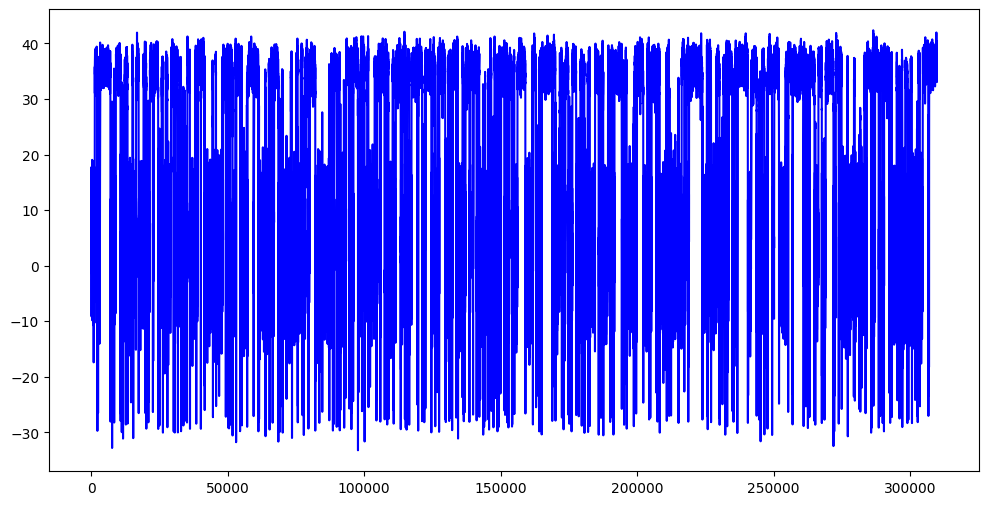

[ 0.07377766  0.33413112  0.84947592  1.6557135   2.84528587  4.44314346
  6.42553993  8.65554406 11.05745541 13.57739023 16.14803927 18.53981078
 20.51496219 21.97480024 22.99906551 23.71819288 24.26438729 24.76882188
 25.32056715 25.9341066  26.53740865 27.07497685 27.51527381 27.84567462
 28.0448215 ] [-0.09694311 -0.1881776  -0.27393069 -0.34715295 -0.40495678 -0.4448176
 -0.46413435 -0.45823808 -0.43171867 -0.37562143 -0.29115039 -0.17322871
 -0.03279489  0.11562891  0.24795491  0.35004159  0.43482162  0.53029982
  0.649033    0.77862381  0.89717514  0.98891648  1.04946406  1.08419343
  1.10157662] [ 0.17072078  0.52230872  1.12340662  2.00286645  3.25024265  4.88796106
  6.88967428  9.11378214 11.48917408 13.95301165 16.43918966 18.7130395
 20.54775707 21.85917133 22.7511106  23.36815129 23.82956567 24.23852206
 24.67153415 25.15548279 25.64023352 26.08606038 26.46580975 26.76148119
 26.94324488]


Text(0.5, 1.0, '')

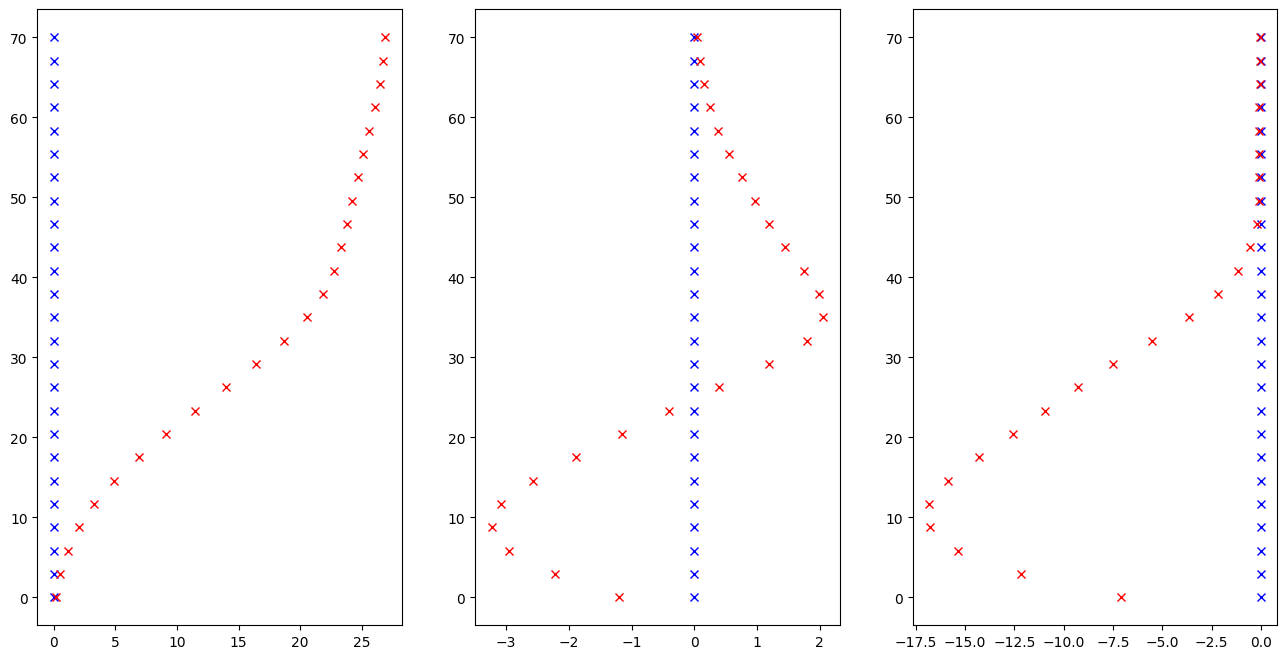

In [32]:
# PREP

import os, random

real_data       = np.load("/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/data/actual/long_run_310k.npy")
save_dir        = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/tests/single_timestep"

num_samples     = 1000
level           = 72
start, end      = (0, 50)

latent_dim      = 32
output_dim      = 75
condition_dim   = 50
num_neurons     = 1024

model_path      = "/home/constantino-daniel-boscu/Documents/research/AI-RES/modified-code-main3/training_cycles/resnet/best_models_kinda/checkpoint_11"

model           = ConditionalVAE(latent_dim, output_dim, condition_dim, num_neurons).cuda()
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Loading model from checkpoint...")
model.eval()

# TESTING

timesteps_num   = 0
time_indices    = random.sample(range(0, real_data.shape[0] - 2), timesteps_num)
print(f"Randomly sampled time steps: {time_indices}")

# === Time series visualization ===
real_data_timeseries = real_data[:, 1, level]
time_steps_all = np.arange(len(real_data_timeseries))

plt.figure(figsize=(12, 6))
plt.plot(time_steps_all, real_data_timeseries, label="Real Data at Level 61", color='blue')

# Mark sample points
for idx_num, idx in enumerate(time_indices):
    plt.axvline(x=idx, color='green', linestyle='--', linewidth=2)
if len(time_indices) > 0:
    plt.axvline(x=time_indices[0], color='green', linestyle='--', linewidth=2, label='Sampled Points')

save_path = os.path.join(save_dir, "real_data_timeseries_with_samples.png")
plt.savefig(save_path)
plt.show()

# === Iterate over each sampled time point ===
for i, time_step in enumerate(time_indices):
    next_time_step = time_step + 1

    # === Real data: current and next ===
    real_current = real_data[time_step, 1, :]       
    real_next = real_data[next_time_step, 1, :]      

    # === Normalize real_current and make prediction for next step ===
    initial_cond = torch.reshape(torch.tensor(psi[time_step,start:end]), [1, num_variables])
    z = torch.zeros([1,latent_dim])
    num_ens = 1
    pred = np.zeros([time_step, num_variables, num_ens])

    with torch.no_grad():
        z = torch.randn_like(z)
        print(z.shape, initial_cond.shape)
        print(z.device, initial_cond.device)
        y = model.decode(z.float().cuda(), initial_cond.float().cuda())
        y = y.detach().cpu().numpy()

    # === Denormalize predicted next ===
    pred_next_denorm = y.squeeze() * std_psi.squeeze() + mean_psi.squeeze()

    # === Extract U, Re(Psi), Im(Psi) components ===
    # U profiles
    U_current_real = real_current[50:75]
    U_next_real = real_next[50:75]
    U_next_pred = pred_next_denorm[50:75]

    # Re(Psi) profiles
    RePsi_current_real = real_current[0:25]
    RePsi_next_real = real_next[0:25]
    RePsi_next_pred = pred_next_denorm[0:25]

    # Im(Psi) profiles
    ImPsi_current_real = real_current[25:50]
    ImPsi_next_real = real_next[25:50]
    ImPsi_next_pred = pred_next_denorm[25:50]

    # === Differences ===
    U_diff_real = U_next_real - U_current_real
    U_diff_pred = U_next_pred - U_current_real

    RePsi_diff_real = RePsi_next_real - RePsi_current_real
    RePsi_diff_pred = RePsi_next_pred - RePsi_current_real

    ImPsi_diff_real = ImPsi_next_real - ImPsi_current_real
    ImPsi_diff_pred = ImPsi_next_pred - ImPsi_current_real

    # === Create a single figure with 3 rows (U, Re(Psi), Im(Psi)) ===
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))  # 3 rows, 2 columns (Profile and Difference)

    z_levels_U = np.linspace(0, 70, 25)
    z_levels_RePsi = np.linspace(0, 70, 25)
    z_levels_ImPsi = np.linspace(0, 70, 25)

    # --- U ---
    axes[0, 0].plot(U_current_real, z_levels_U, 'x-', label="Real Current")
    axes[0, 0].plot(U_next_real, z_levels_U, 'd-', label="Real Next")
    axes[0, 0].plot(U_next_pred, z_levels_U, 's--', label="Predicted Next")
    axes[0, 0].set_title(f"U Profiles @ Step {time_step}")
    axes[0, 0].set_xlabel("U (m/s)")
    axes[0, 0].set_ylabel("Vertical Levels (km)")
    axes[0, 0].legend()

    axes[0, 1].plot(U_diff_real, z_levels_U, 'xb', label="Real Δ (Next - Current)")
    axes[0, 1].plot(U_diff_pred, z_levels_U, 'o--r', label="Pred Δ (Next - Current)")
    axes[0, 1].set_title("U Difference (Next - Current)")
    axes[0, 1].set_xlabel("ΔU (m/s)")
    axes[0, 1].legend()

    # --- Re(Psi) ---
    axes[1, 0].plot(RePsi_current_real, z_levels_RePsi, 'x-', label="Real Current")
    axes[1, 0].plot(RePsi_next_real, z_levels_RePsi, 'd-', label="Real Next")
    axes[1, 0].plot(RePsi_next_pred, z_levels_RePsi, 's--', label="Predicted Next")
    axes[1, 0].set_title(f"Re(Psi) Profiles @ Step {time_step}")
    axes[1, 0].set_xlabel("Re(Psi)")
    axes[1, 0].set_ylabel("Vertical Levels (km)")
    axes[1, 0].legend()

    axes[1, 1].plot(RePsi_diff_real, z_levels_RePsi, 'xb', label="Real Δ (Next - Current)")
    axes[1, 1].plot(RePsi_diff_pred, z_levels_RePsi, 'o--r', label="Pred Δ (Next - Current)")
    axes[1, 1].set_title("Re(Psi) Difference (Next - Current)")
    axes[1, 1].set_xlabel("ΔRe(Psi)")
    axes[1, 1].legend()

    # --- Im(Psi) ---
    axes[2, 0].plot(ImPsi_current_real, z_levels_ImPsi, 'x-', label="Real Current")
    axes[2, 0].plot(ImPsi_next_real, z_levels_ImPsi, 'd-', label="Real Next")
    axes[2, 0].plot(ImPsi_next_pred, z_levels_ImPsi, 's--', label="Predicted Next")
    axes[2, 0].set_title(f"Im(Psi) Profiles @ Step {time_step}")
    axes[2, 0].set_xlabel("Im(Psi)")
    axes[2, 0].set_ylabel("Vertical Levels (km)")
    axes[2, 0].legend()

    axes[2, 1].plot(ImPsi_diff_real, z_levels_ImPsi, 'xb', label="Real Δ (Next - Current)")
    axes[2, 1].plot(ImPsi_diff_pred, z_levels_ImPsi, 'o--r', label="Pred Δ (Next - Current)")
    axes[2, 1].set_title("Im(Psi) Difference (Next - Current)")
    axes[2, 1].set_xlabel("ΔIm(Psi)")
    axes[2, 1].legend()

    # === Finalize and Save ===
    plt.suptitle(f"Single Step Profile Comparisons at Time Step {time_step}", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    save_path = os.path.join(save_dir, f"Profile_Summary_point_{time_step}.png")
    plt.savefig(save_path)
    plt.show()

    print(f"Combined plot saved for sampled point {time_step}")

# === Mean and Standard Deviation of Differences ===

num_samples             = 1
time_indices            = random.sample(range(0, real_data.shape[0] - 2), num_samples)
U_saved_diffs           = np.zeros([num_samples, 25])
RePsi_saved_diffs       = np.zeros([num_samples, 25])
ImPsi_saved_diffs       = np.zeros([num_samples, 25])

for i, time_step in enumerate(time_indices):

    initial_cond = torch.reshape(torch.tensor(psi[time_step,start:end]), [1, num_variables])
    z = torch.zeros([1,latent_dim])

    with torch.no_grad():
        z = torch.randn_like(z)
        y = model.decode(z.float().cuda(), initial_cond.float().cuda())
        y = y.detach().cpu().numpy()

    pred_next_denorm = y.squeeze() * std_psi.squeeze() + mean_psi.squeeze()

    # U profiles
    U_current_real = real_current[50:75]
    U_next_real = real_next[50:75]
    U_next_pred = pred_next_denorm[50:75]

    # Re(Psi) profiles
    RePsi_current_real = real_current[0:25]
    RePsi_next_real = real_next[0:25]
    RePsi_next_pred = pred_next_denorm[0:25]

    # Im(Psi) profiles
    ImPsi_current_real = real_current[25:50]
    ImPsi_next_real = real_next[25:50]
    ImPsi_next_pred = pred_next_denorm[25:50]

    # === Differences ===
    U_diff_real = U_next_real - U_current_real
    U_diff_pred = U_next_pred - U_current_real

    RePsi_diff_real = RePsi_next_real - RePsi_current_real
    RePsi_diff_pred = RePsi_next_pred - RePsi_current_real

    ImPsi_diff_real = ImPsi_next_real - ImPsi_current_real
    ImPsi_diff_pred = ImPsi_next_pred - ImPsi_current_real

    # === Error between Differences of Real and Predicted ===

    U_diff_of_delta = U_diff_pred - U_diff_real
    print(U_diff_pred, U_diff_real, U_diff_of_delta)
    RePsi_diff_of_delta = RePsi_diff_pred - RePsi_diff_real
    ImPsi_diff_of_delta = ImPsi_diff_pred - ImPsi_diff_real

    U_saved_diffs[i, :] = U_diff_of_delta
    RePsi_saved_diffs[i, :] = RePsi_diff_of_delta
    ImPsi_saved_diffs[i, :] = ImPsi_diff_of_delta

Mean_U = np.mean(U_saved_diffs, axis = 0)
Std_U = np.std(U_saved_diffs, axis = 0)
Mean_RePsi = np.mean(RePsi_saved_diffs, axis = 0)
Std_RePsi = np.std(RePsi_saved_diffs, axis = 0)
Mean_ImPsi = np.mean(ImPsi_saved_diffs, axis = 0)
Std_ImPsi = np.std(ImPsi_saved_diffs, axis = 0)

fig, axes = plt.subplots(1, 3, figsize=(16, 8))

zeros = np.zeros((25,))
axes[0].plot(zeros, z_levels_U, 'xb')
axes[0].errorbar(Mean_U, z_levels_U, xerr = Std_U, fmt = 'xr')
axes[1].plot(zeros, z_levels_U, 'xb')
axes[1].errorbar(Mean_RePsi, z_levels_RePsi, xerr = Std_RePsi, fmt = 'xr')
axes[2].plot(zeros, z_levels_U, 'xb')
axes[2].errorbar(Mean_ImPsi, z_levels_ImPsi, xerr = Std_ImPsi, fmt = 'xr')
plt.title("")
        